In [ ]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sinekan_fit_info = pkl.load(open('/content/drive/MyDrive/sinekan_fit_info.pkl', 'rb'))
sinekan_errors = pkl.load(open('/content/drive/MyDrive/sinekan_errors.pkl', 'rb'))

In [ ]:
# Maximum value of G
G_max = 80

# Discretize x over [0, 1]
x_values = np.linspace(0, 1, 1000)+1e-2

In [ ]:
def truncated_series(coeffs, x, G=None):
    """
    coeffs : complex FFT array of length N (as returned by np.fft.fft)
    x      : points in [0, 1) at which to evaluate the series
    G      : number of positive-frequency harmonics to keep
             (defaults to floor(N/2) – i.e. full inverse FFT)
    """
    import numpy as np
    coeffs = np.asarray(coeffs)
    x      = np.asarray(x, dtype=float)

    N = coeffs.size
    if G is None:
        G = N // 2

    # ----- indices of the cos/sin pairs we really keep -----
    k = np.arange(1, G + 1)
    has_nyq = (N % 2 == 0) and (G >= N // 2)
    if has_nyq:                     # drop k = N/2 – we’ll handle it once, separately
        k = k[k != N // 2]

    # constant (k = 0) term
    s = coeffs[0].real / N

    # Nyquist (k = N/2) term – no factor 2, no sine component
    if has_nyq:
        s += (coeffs[N // 2].real / N) * np.cos(np.pi * N * x)

    # ordinary cos/sin pairs
    a_k = coeffs[k].real
    b_k = coeffs[k].imag
    s += (2.0 / N) * (
        a_k[:, None] * np.cos(2 * np.pi * k[:, None] * x) -
        b_k[:, None] * np.sin(2 * np.pi * k[:, None] * x)
    ).sum(axis=0)

    return s


$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 1, rel L2=2.851e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 2, rel L2=2.326e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 3, rel L2=1.978e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 4, rel L2=1.690e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 5, rel L2=1.489e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 6, rel L2=1.347e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 7, rel L2=1.238e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 8, rel L2=1.148e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G= 9, rel L2=1.071e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G=10, rel L2=1.005e-01
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G=11, rel L2=9.488e-02
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$: G=12, rel L2=9.001e-02
$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right

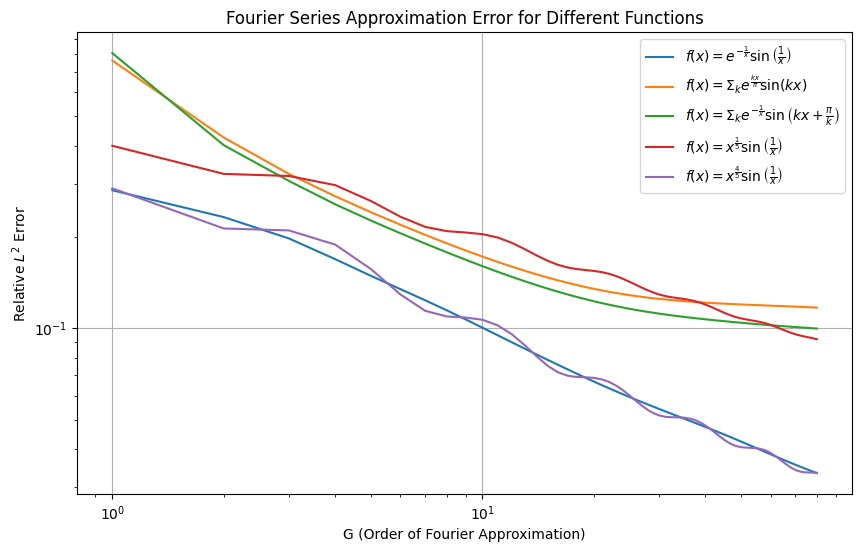

In [ ]:
def inv_sine_exponential(x):
    output = np.exp(-1/x)*np.sin(1/x)
    return output

def sine_exponential(x, k=10):
    output = 0
    for i in range(k):
        output += np.exp(k*x/np.pi)*np.sin(k*x)
    return output

def sine_with_phase(x, k=10):
    output = 0
    for i in range(k):
        output = np.exp(-1/x)*np.sin(k*x + np.pi/k)
    return output

def root_sine_low(x, alpha=0.2):
    output = x**alpha*np.sin(1/x)
    return output

def root_sine_high(x, alpha=0.8):
    output = x**alpha*np.sin(1/x)
    return output

test_funcs = [inv_sine_exponential, sine_exponential, sine_with_phase, root_sine_low, root_sine_high]
function_names_latex = [
    r"$f(x) = e^{-\frac{1}{x}} \sin\left(\frac{1}{x}\right)$",
    r"$f(x) = \Sigma_k e^{\frac{kx}{\pi}} \sin(kx)$",
    r"$f(x) = \Sigma_k e^{-\frac{1}{x}} \sin\left(kx + \frac{\pi}{k}\right)$",
    r"$f(x) = x^{\frac{1}{5}} \sin\left(\frac{1}{x}\right)$",
    r"$f(x) = x^{\frac{4}{5}} \sin\left(\frac{1}{x}\right)$",
]

fourier_errors = []

# Set up the domain
epsilon = 1e-2
num_points = 1000
x_values = np.linspace(epsilon, 1, num_points)
L = 1-epsilon  # Interval length

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop over each function
for func, func_name in zip(test_funcs, function_names_latex):
    f_vals = func(x_values)

    # FFT-space coefficients
    coeffs = np.fft.fft(f_vals) # normalised to dimensionality
    shift   = np.exp(-2j*np.pi*np.arange(num_points)*epsilon)
    coeffs *= shift

    # energy (L2-norm) of the function over the continuous domain
    norm_f = np.sqrt(np.sum(np.abs(f_vals)**2) * (L/num_points))

    errors = []

    for G in range(1, G_max+1):
        # reconstruct with inverse FFT
        S_G = truncated_series(coeffs, x_values, G=G)

        # L2 error
        err = np.sqrt(np.sum((f_vals - S_G)**2) * (L/num_points)) / norm_f
        errors.append(err)

        print(f"{func_name}: G={G:2d}, rel L2={err:.3e}")

    plt.plot(range(1, G_max+1), errors, label=func_name)

    fourier_errors.append(errors)

# Finalize the plot
plt.xlabel('G (Order of Fourier Approximation)')
plt.ylabel('Relative $L^2$ Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Fourier Series Approximation Error for Different Functions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.rcParams['font.size'] = 16

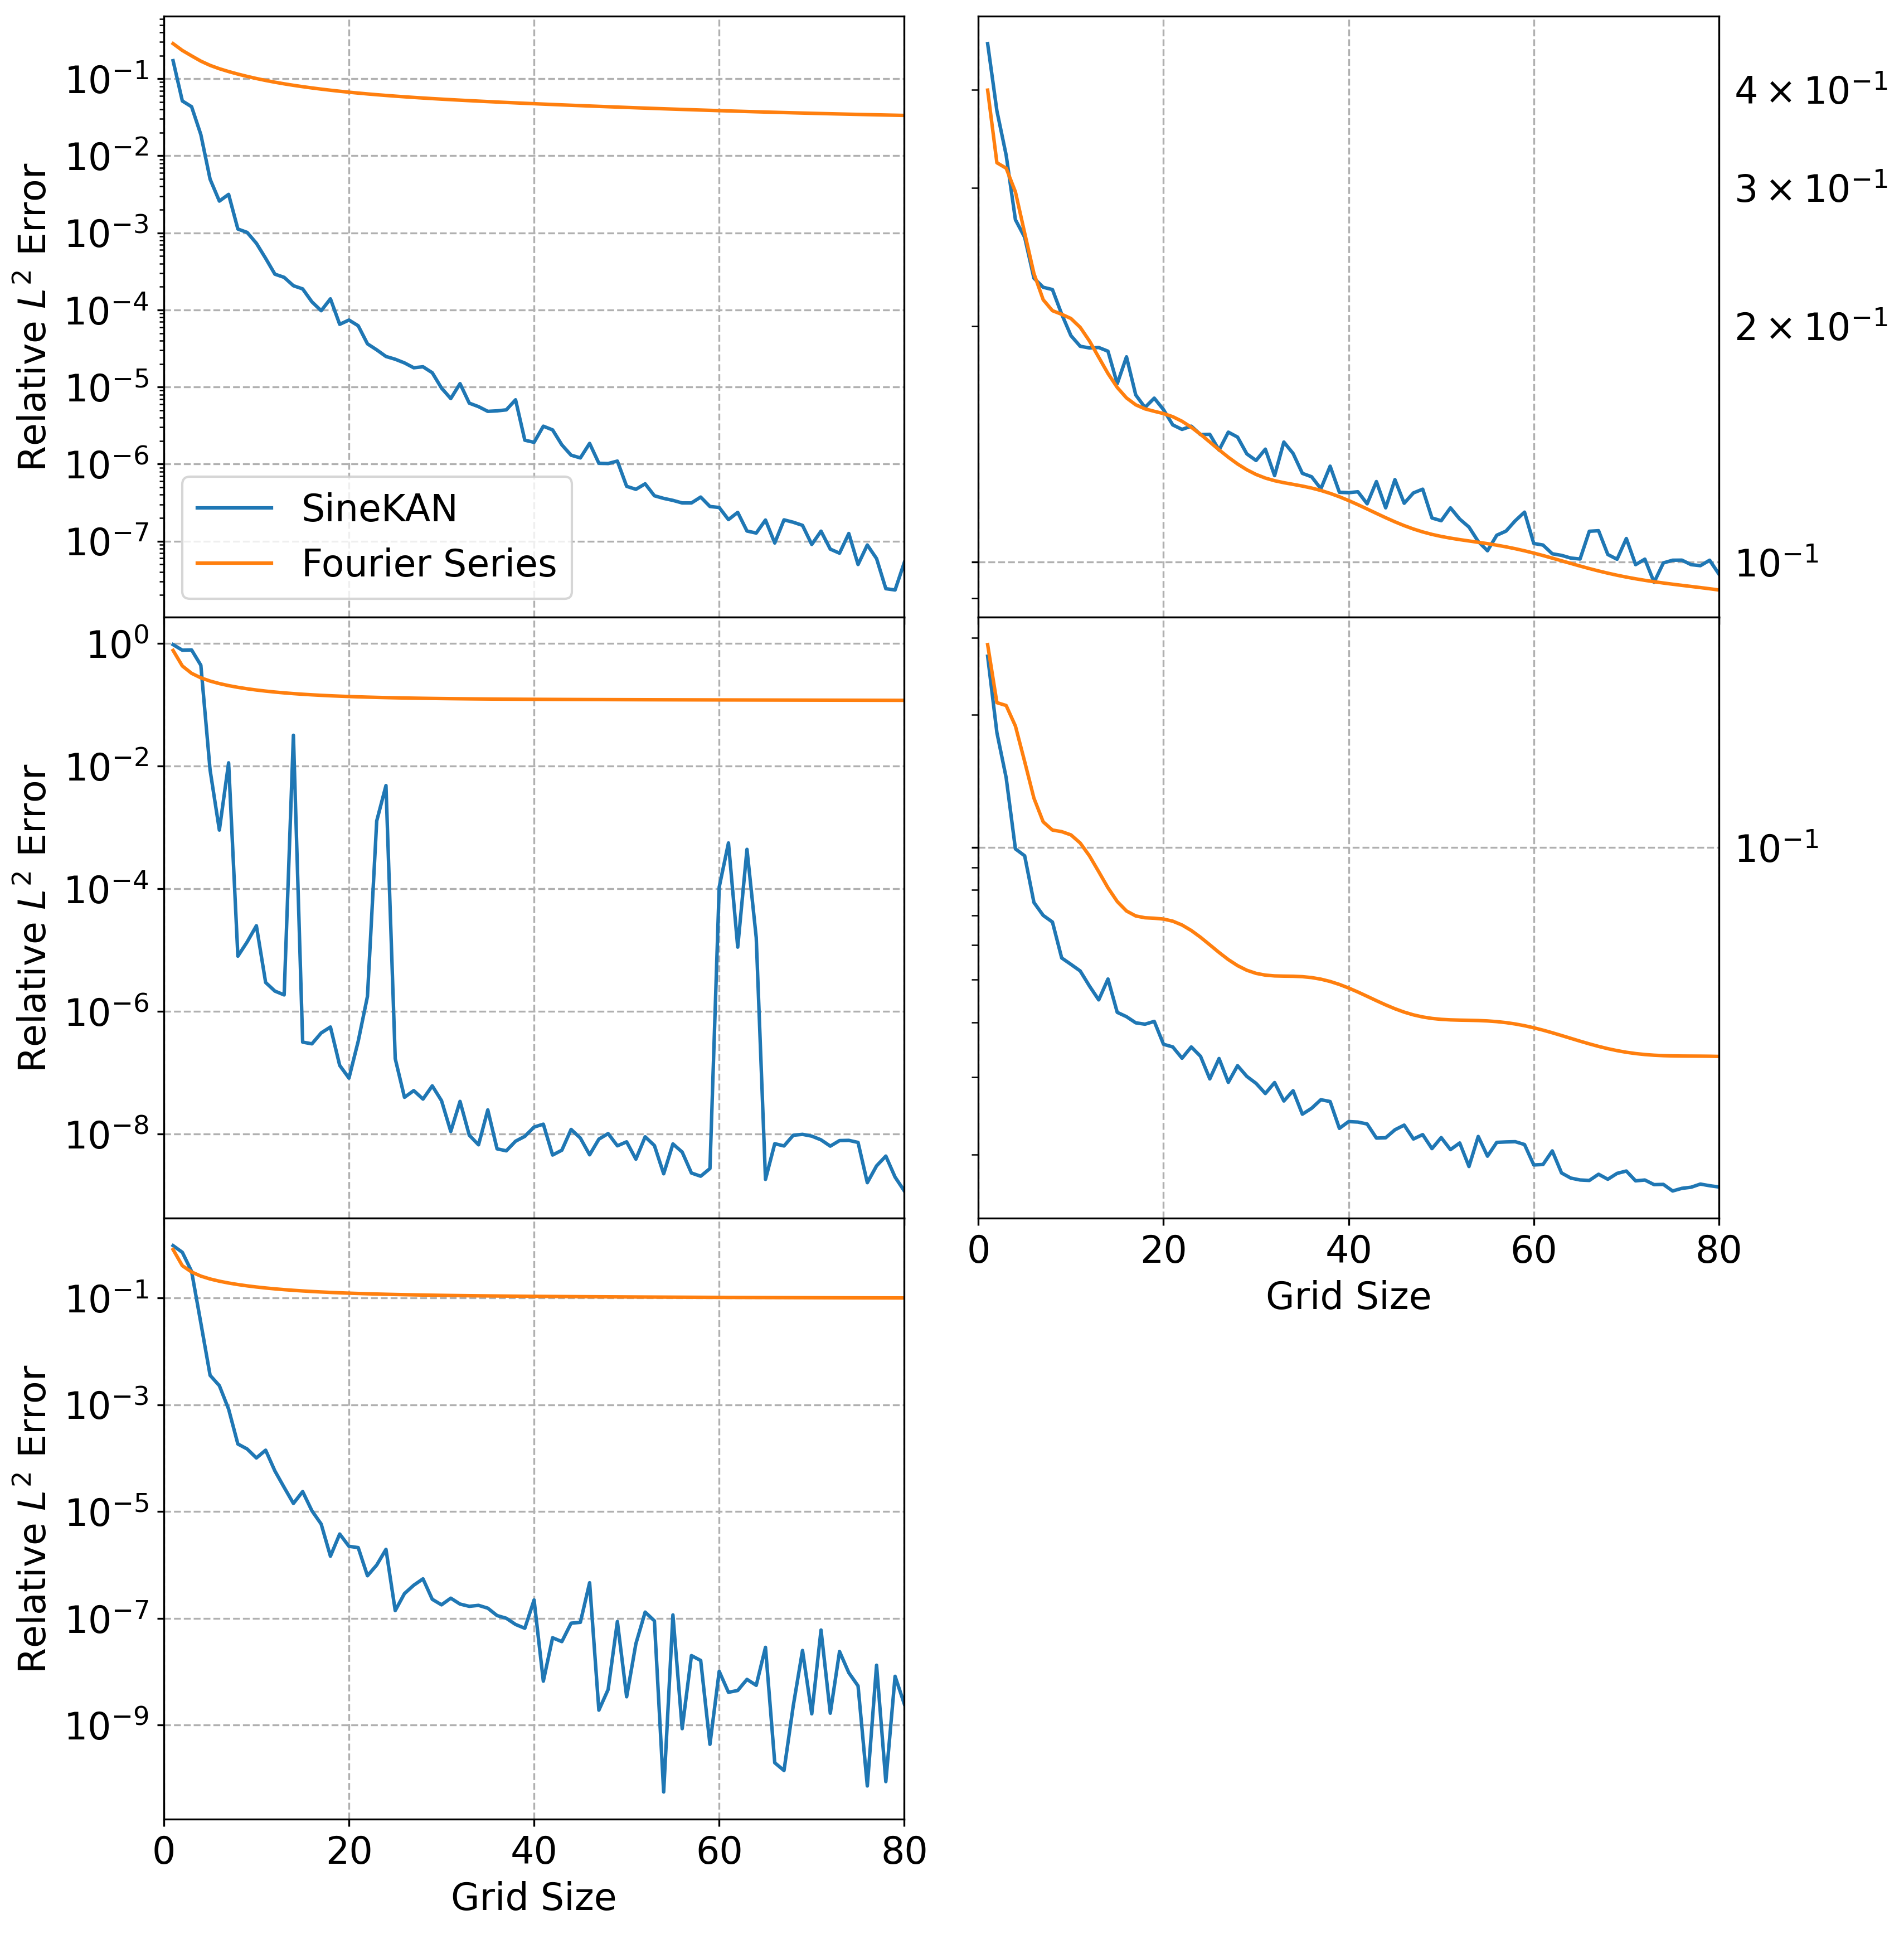

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 14), dpi=300)
slot = [(0, 0), (1, 0), (2, 0),
        (0, 1), (1, 1)]

for i, (f_errs, func_name) in enumerate(zip(fourier_errors, function_names_latex)):
    r, c           = slot[i]
    ax_i           = ax[r, c]

    ax_i.plot(range(1, G_max + 1), sinekan_errors[i], label="SineKAN")
    ax_i.plot(range(1, G_max + 1), f_errs,             label="Fourier Series")

    if c == 0:
        ax_i.set_ylabel("Relative $L^2$ Error")
    if (r, c) in [(2, 0), (1, 1)]:
        ax_i.set_xlabel("Grid Size")

    ax_i.set_yscale("log")
    ax_i.set_xlim(0, 80)
    ax_i.grid(linestyle="--")

fig.delaxes(ax[2, 1])

ax[0,0].tick_params(axis='both', labelleft=True, labelbottom=False, length=3)
ax[1,0].tick_params(axis='both', labelleft=True, labelbottom=False, length=3)
ax[2,0].tick_params(axis='both', labelleft=True,  length=3)
ax[0,1].tick_params(axis='both', which='both', labelleft=False, labelright=True, labelbottom=False, length=3)
ax[1,1].tick_params(axis='both', which='both', labelleft=False, labelright=True,  length=3)

ax[0, 0].legend()
fig.subplots_adjust(hspace=0, wspace=0.1)
plt.show()
